<center> <h1> Natural Language Processing - Assignment # 2 </h1> 
    Lorenzo Pratesi <a href="mailto:lorenzo.pratesi2@studio.unibo.it">lorenzo.pratesi2@studio.unibo.it</a> <br>
        Martina Rossini <a href="mailto:martina.rossini3@studio.unibo.it">martina.rossini3@studio.unibo.it</a> <br>
        Riccardo Foschi <a href="mailto:riccardo.foschi4@studio.unibo.it">riccardo.foschi4@studio.unibo.it</a> <br>
        Vairo Di Pasquale <a href="mailto:vairo.dipasquale@studio.unibo.it">vairo.dipasquale@studio.unibo.it</a> <br> <br>
        <a link=https://github.com/NLP-Team-Unibo/Assignement_2>GitHub</a>
    <center>

### Download and Preproces Dataset 

First, let's install and import the necessary Python libraries. Note that we require a specific version of pandas: indeed, versions before 1.2.5 produce a different behaviour when calling pd.Series.mode, a function we employ when computing the majority class for a claim given the predictions for single <code> (claim, evidence)</code> pairs.

In [1]:
!pip install gensim==4.0.0
!pip install pandas==1.2.5

In [2]:
# General Python libraries
import os
import sys
import zipfile
import requests
from tqdm import tqdm

# Data processing libraries
import numpy as np
import pandas as pd

# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Machine Learning / Deep Learning / Language modelling libraries
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

import gensim
import gensim.downloader as gloader

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.math import reduce_mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Average, Add, Dot, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Bidirectional, Dense, Flatten 

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/students/vairo.dipasquale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/students/vairo.dipasquale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now, we can proceed by downloading and extracting the given dataset.

In [3]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Let's load the datasets using Pandas.

In [4]:
df_train = pd.read_csv('dataset/train_pairs.csv', delimiter=',')
df_val = pd.read_csv('dataset/val_pairs.csv', delimiter=',')
df_test = pd.read_csv('dataset/test_pairs.csv', delimiter=',')

Showing the first rows of the train dataset.

In [5]:
df_train.head()

,Unnamed: 0,Claim,Evidence,ID,Label
0,0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


In [6]:
df_train['Evidence'][1]

'0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .\tfighter pilot\tfighter pilot'

#### Exploratory Data Analysis

Let's compare the number of samples in each dataset.

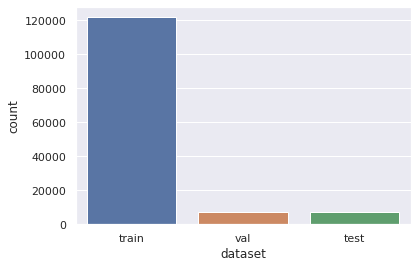

In [7]:
# Counting the samples in each data split
sns.set(color_codes=True)

concatenated = pd.concat([df_train.assign(dataset='train'),
                          df_val.assign(dataset='val'),
                          df_test.assign(dataset='test')])

sns.countplot(x='dataset', data=concatenated)
plt.show()

The train samples are a lot more than the validation and test sets. 
Let's show the classes distribution.

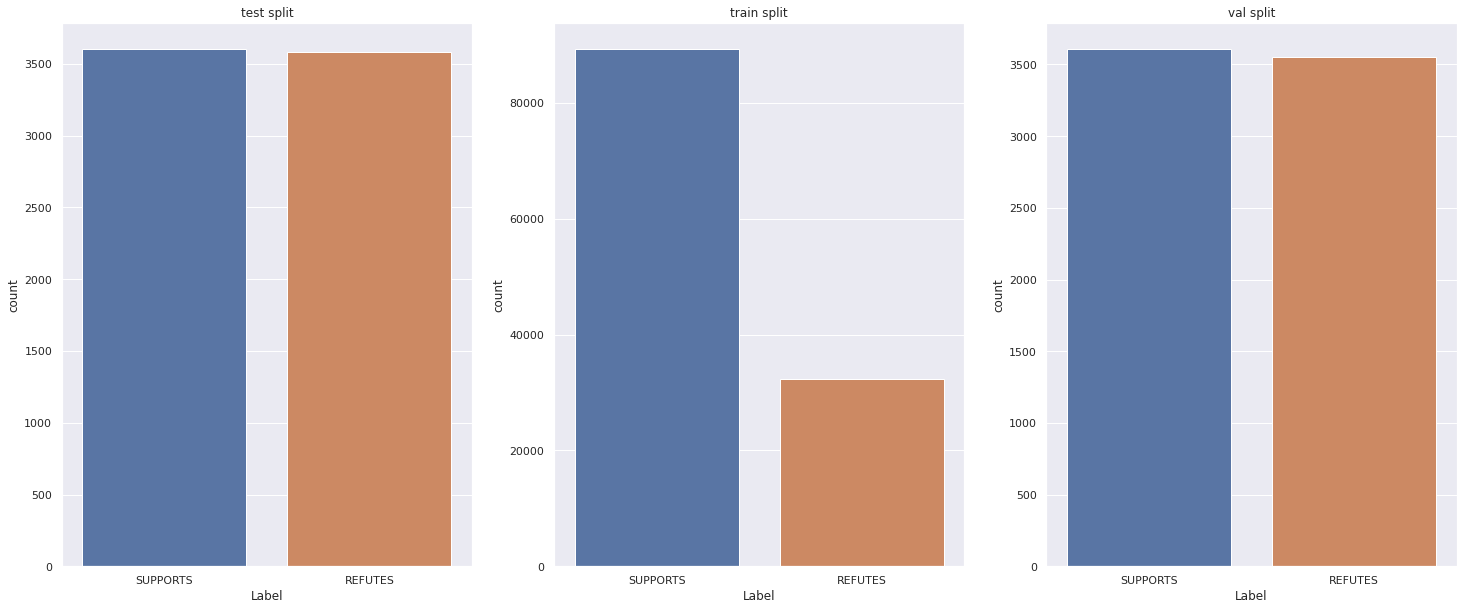

In [8]:
_, axes = plt.subplots(1, 3, figsize=(25, 10))
for split, ax in zip(np.unique(concatenated['dataset'].values), axes.tolist()):
    ax.set_title(split + ' split')
    sns.countplot(x='Label', data=concatenated[concatenated['dataset'] == split], ax=ax)
plt.show()

In the training set, the number of <code>SUPPORTS</code> samples are a lot more than the <code>REFUTES</code> one. We'll address this imbalance problem later by using class weights during training.

Note however that the classes' distribution in the train set is quite different from the one we find in both test and validation sets. This will probably result in significantly worse results (w.r.t. the training scores) when evaluating our model; indeed, a classifier usually performs well on a dataset it hasn’t seen before if it comes from the same distribution as the one it was trained on.

In [9]:
def preprocess_sentence(text, pipeline, evidence=False, tokenizer=None):
    """
    Takes as input a sentence and returns the sentence modified according to the regex pipeline

    text: str
        The input sentence
    pipeline: dict
        A dictionary containing regex as key and a string to be substituted to the matched regex as value
    evidence: bool
        If True, remove the first word from the input text
    tokenizer: None or function
        If is a function, apply it to the text to get a list of tokens
    """
    text = text.lower()
    for key, value in pipeline.items():
        text = key.sub(value, text)
        
    if evidence:
        text = " ".join(text.split()[1:])
    else:
        text = " ".join(text.split())
    if tokenizer:
        text = tokenizer(text) 
    return text

Now, we are going to apply some preprocessing to the texts; in particular we'll bring to lowercase everything and remove all the non-alphanumerical characters.

In [10]:
replace_others = re.compile('[^0-9a-zA-Z\s\']')

pipeline = {
    replace_others: ' ',
}

sentences = df_train['Claim'].apply(preprocess_sentence, args=[pipeline]).to_list() \
                + df_train['Evidence'].apply(preprocess_sentence, args=[pipeline, True]).to_list()
sentences = pd.Series(list(map(lambda x: x.split(' '), sentences))).explode()         

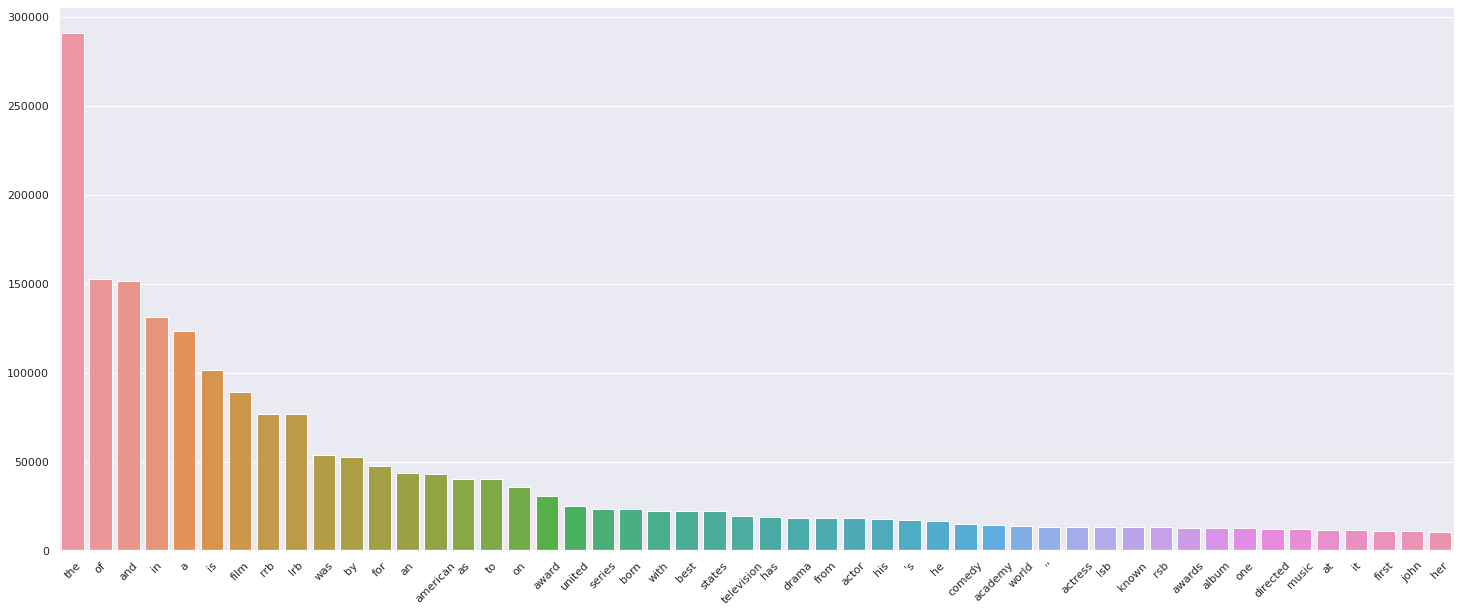

In [11]:
# Plotting the 50 most frequent OOVs
word_occurrence = sentences.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=word_occurrence.keys(), y=word_occurrence.values, ax=ax)
plt.xticks(rotation=45)
plt.show()

The majority of the tokens are stopwords, but there are also parenthesis (rrb/lrb) and double quotes. Let's remove definitively the last two and temporarly remove the stopwords for visualization purposes.

Note that we decided not to remove stopwords when actually preparing the data for training because a lot of the tokens included in NLTK's list are negations and it is reasonable to think that they play an important role in our task, seeing as we need to decide whether a <code>claim</code> is supported or refuted by a piece of <code>evidence</code>.

In [12]:
stop_words = set(stopwords.words('english'))
remove_par = re.compile('(-rrb-)|(-lrb-)')
remove_quotes = re.compile('(\'\'+)')
pipeline = {
    remove_par: ' ',
    remove_quotes: '',
    replace_others: ' ',
}

sentences = df_train['Claim'].apply(preprocess_sentence, args=[pipeline]).to_list() \
                + df_train['Evidence'].apply(preprocess_sentence, args=[pipeline, True]).to_list()
sentences = pd.Series(list(map(lambda x: x.split(' '), sentences))).explode()   
sentences = sentences[sentences.apply(lambda x: x not in stop_words)]

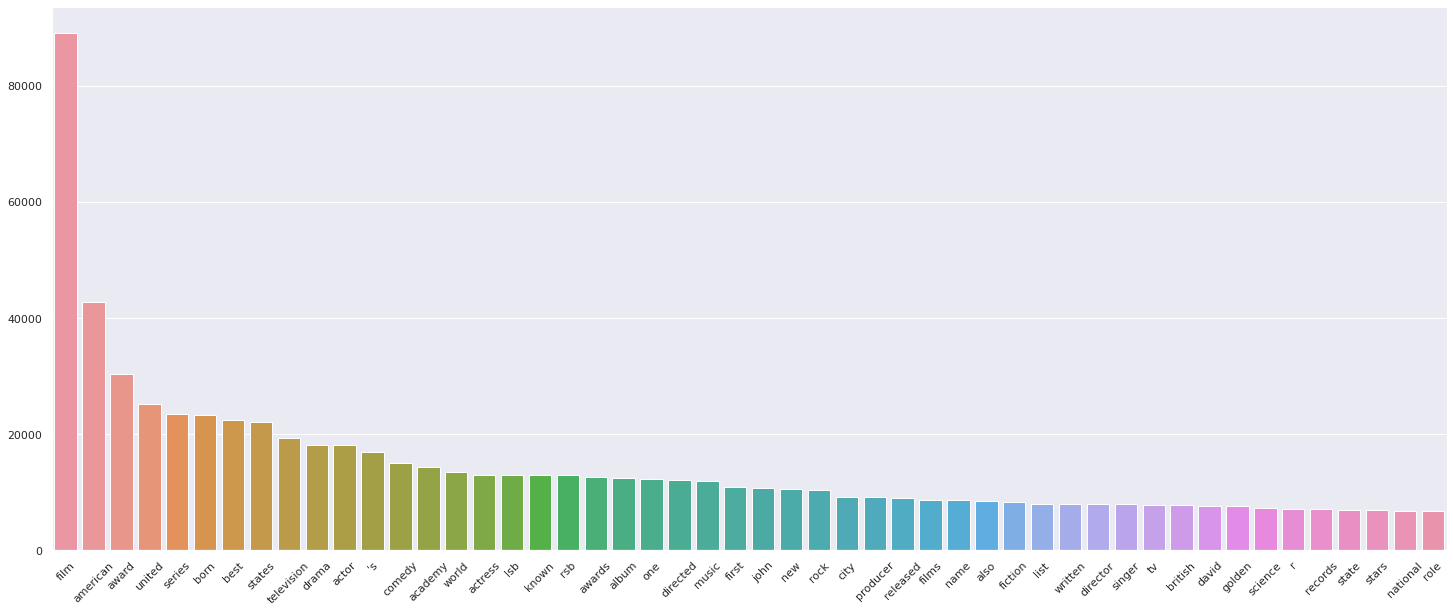

In [13]:
word_occurrence = sentences.value_counts()[:50]
_, ax = plt.subplots(figsize=(25, 10))
sns.barplot(x=word_occurrence.keys(), y=word_occurrence.values, ax=ax)
plt.xticks(rotation=45)
plt.show()

There are still some other type of parenthesis (lsb/rsb) as most frequent tokens. Before removing them, let's print what is inside this type of tokens.

In [14]:
sentences = df_train['Claim'].to_list() \
                + df_train['Evidence'].to_list()
result = []
list(map(lambda x: result.append(x) if x.lower().find('-lsb-') != -1 else 0, sentences));
np.unique(result)[:10]

array(['0\t, more commonly known simply as Seiko -LRB- -LSB- ˈseɪkoʊ -RSB- -RRB- , is a Japanese holding company that holds subsidiaries which manufactures and sells watches , clocks , electronic devices , semiconductors , jewelries , and optical products .\tholding company\tholding company\tjewelries\tJewellery\toptical products\toptics',
       '0\t-LRB- -LSB- jəˈmɑːhə -RSB- or -LSB- ˈjɑːməhə -RSB- -LSB- jamaha -RSB- -RRB- is a Japanese multinational corporation and conglomerate based in Japan with a very wide range of products and services , predominantly musical instruments , electronics , motorcycles and power sports equipment .\tJapan\tJapan\tmultinational corporation\tmultinational corporation\tconglomerate\tConglomerate (company)\tmusical instruments\tmusical instruments\telectronics\telectronics\tmotorcycles\tmotorcycles\tsports\tsports',
       '0\t-LRB- -LSB- langwɑːluˈiːdʒi -RSB- -RRB- is a character in the Mario franchise .\tMario\tMario',
       '0\tA Mediterranean climat

All the words inside square parenthesis seem to contain phonetic information; thus, we will remove everything that is inside this type of brackets.

After that, we finally apply the final preprocessing function to both claims and evidences of all the sets.

In [15]:
replace_others = re.compile('[^0-9a-zA-Z\s\']')
replace_par = re.compile('(-rrb-)|(-lrb-)')
replace_phonetics = re.compile('(-lsb-.*-rsb-)')
replace_quotes = re.compile('(\'\'+)')

pipeline = {
    replace_phonetics: '',
    replace_quotes: '',
    replace_par: ' ',
    replace_others: ' '
}

tokenizer = lambda x: x.split(' ')
X_train_claim_pre = df_train['Claim'].apply(preprocess_sentence, args=[pipeline, False, tokenizer])
X_train_evidence_pre = df_train['Evidence'].apply(preprocess_sentence, args=[pipeline, True, tokenizer])

X_val_claim_pre = df_val['Claim'].apply(preprocess_sentence, args=[pipeline, False, tokenizer])
X_val_evidence_pre = df_val['Evidence'].apply(preprocess_sentence, args=[pipeline, True, tokenizer]) 

X_test_claim_pre = df_test['Claim'].apply(preprocess_sentence, args=[pipeline, False, tokenizer])
X_test_evidence_pre = df_test['Evidence'].apply(preprocess_sentence, args=[pipeline, True, tokenizer]) 
print(X_train_claim_pre)

0         [chris, hemsworth, appeared, in, a, perfect, g...
1                              [roald, dahl, is, a, writer]
2                            [roald, dahl, is, a, governor]
3         [ireland, has, relatively, low, lying, mountains]
4         [ireland, does, not, have, relatively, low, ly...
                                ...                        
121735    [april, was, the, month, anderson, silva, was,...
121736    [anderson, silva, is, an, american, brazilian,...
121737    [anderson, silva, is, incapable, of, being, a,...
121738    [anderson, silva, was, born, on, the, month, o...
121739    [anderson, silva, was, born, on, the, day, of,...
Name: Claim, Length: 121740, dtype: object


Let's download the pre-trained GloVe embeddings using the <code>gensim</code> library. Note that we choose to use 300 as embedding size

In [16]:
def load_glove(embedding_dimension=50):
    """
    Load pre-computed GloVe embeddings using the gensim library.

    Parameters
    ----------
    embedding_dimension: {50, 100, 200, 300}, default: 50
        Dimension of the vectors to load. 
    
    Returns
    -------
    gensim.models.keyedvectors
        Gensim model containing the requested embeddings
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e
    return emb_model

EMBEDDING_DIM = 300
gloves = load_glove(EMBEDDING_DIM)

### Vocabulary creation and sequence encoding

We are now going to create the token vocabulary, that will be used in the indexing of the embedding matrix. In order to do it, we will use the Tokenizer class of Keras. We will call the <code>fit_on_texts</code> method on the GloVe's keys and on the training sentences. We do so because we want to randomly instantiate the embeddings for words in the training set but not in GloVe. For what concerns the tokens of the other sets, the <code>texts_to_sequences</code> method will assign to them a special unique index, representing the OOV embedding.

Using the created vocabulary, we will generate also the sequences that we will feed to the network. Each token will be replaced with the corresponding index in the vocabulary.

In [17]:
word_tok = Tokenizer(oov_token='<UNK>', filters=[])

word_tok.fit_on_texts(gloves.key_to_index.keys())

word_tok.fit_on_texts(X_train_claim_pre)
word_tok.fit_on_texts(X_train_evidence_pre)

X_train_claim_enc = word_tok.texts_to_sequences(X_train_claim_pre)
X_train_evidence_enc = word_tok.texts_to_sequences(X_train_evidence_pre)

X_val_claim_enc = word_tok.texts_to_sequences(X_val_claim_pre)
X_val_evidence_enc = word_tok.texts_to_sequences(X_val_evidence_pre)

X_test_claim_enc = word_tok.texts_to_sequences(X_test_claim_pre)
X_test_evidence_enc = word_tok.texts_to_sequences(X_test_evidence_pre)

In [18]:
print(len(word_tok.word_index))

403489


In [19]:
print(X_train_evidence_enc[1])

[5061, 4535, 434, 180, 6445, 516, 206, 633, 9, 6, 66, 778, 518, 189, 182, 1401, 231, 4, 1655, 1260, 1655, 1260, 1655, 1260]


### Padding sequences


Next, we will zero-pad the claims and evidences we previously encoded. It is necessary because they often have different lengths. The pad values will be masked out and discarded during the training.

In [20]:
y_mapping = {'SUPPORTS': 0, 'REFUTES': 1}
y_train_enc = df_train['Label'].apply(lambda x: y_mapping[x])
y_val_enc = df_val['Label'].apply(lambda x: y_mapping[x])
y_test_enc = df_test['Label'].apply(lambda x: y_mapping[x])

In [21]:
class PadSequences:
    def __init__(self, train_claim, train_evidence):
        """
        This class allow to zero-pad the encoded sequences based on the model architecture

        Parameters
        ----------
        train_claim: list
            A list containing the encoded sequences of the claims of the training set
        train_claim: list
            A list containing the encoded sequences of the evidences of the training set
        """
        self.max_len = self._get_max_seq_lenght(train_claim, train_evidence)

    def _get_max_seq_lenght(self, claims, evidence):
        max_claim = max(map(lambda x: len(x), claims))
        max_evidence = max(map(lambda x: len(x), evidence))
        max_seq_len = max(max_claim, max_evidence)
        return max_seq_len
    
    def pad_seqs(self, claims, evidences, mode='other'):
        """
        This method takes as input the sequences of claims and evidences and returns their padded version, based on the modality

        Parameters
        __________
        claims: list
            A list containing the encoded sequences of the claims
        evidences: list
            A list containing the encoded sequences of the evidences
        mode: str
            If 'mlp' the sequences will be padded according to the maximum sentence length found in the training set, otherwise this 
            method will return the sequences padded according to their own maximum length
        """
        if mode == 'mlp':
            padded_claims = pad_sequences(claims, maxlen=self.max_len, padding='post')
            padded_evidences = pad_sequences(evidences, maxlen=self.max_len, padding='post')
        else:
            max_claim = max(map(lambda x: len(x), claims))
            max_evidence = max(map(lambda x: len(x), evidences))
            padded_claims = pad_sequences(claims, maxlen=max_claim, padding='post')
            padded_evidences = pad_sequences(evidences, maxlen=max_evidence, padding='post')
        return (padded_claims, padded_evidences)

In [22]:
padding_helper = PadSequences(X_train_claim_enc, X_train_evidence_enc)

X_train_claim_pad, X_train_evidence_pad = padding_helper.pad_seqs(X_train_claim_enc, X_train_evidence_enc)
X_val_claim_pad, X_val_evidence_pad = padding_helper.pad_seqs(X_val_claim_enc, X_val_evidence_enc)
X_test_claim_pad, X_test_evidence_pad = padding_helper.pad_seqs(X_test_claim_enc, X_test_evidence_enc)

X_train_claim_pad_mlp, X_train_evidence_pad_mlp = padding_helper.pad_seqs(X_train_claim_enc, X_train_evidence_enc, mode='mlp')
X_val_claim_pad_mlp, X_val_evidence_pad_mlp = padding_helper.pad_seqs(X_val_claim_enc, X_val_evidence_enc, mode='mlp')
X_test_claim_pad_mlp, X_test_evidence_pad_mlp = padding_helper.pad_seqs(X_test_claim_enc, X_test_evidence_enc, mode='mlp')

### Embedding matrix

Let's compute <code>max_v</code> and <code>min_v</code>, respectively the vectors containing the element wise maximum and minimum among all the GloVe embeddings.

We will use them to upper/lower bound the random values assigned to each dimension of new random embeddings.

In [23]:
max_v = np.ones(EMBEDDING_DIM)*-sys.float_info.max
min_v = np.ones(EMBEDDING_DIM)*sys.float_info.max
for emb in gloves.vectors:
    max_v = np.maximum(max_v, emb)
    min_v = np.minimum(min_v, emb)

Let's build the embedding matrix using the GloVes embeddings and the vocabulary previously created

In [24]:
def build_embedding_matrix(embeddings, embedding_size, word_to_idx):
    """
    Build embedding matrix that will be used for the Keras Embedding 
    layer. 

    Parameters
    ----------
    embeddings: gensim.models.keyedvectors
        GloVe embeddings of the given size
    embedding_size: {50, 100, 200, 300}
        Size of the embedding vectors to be generated. Note that it must
        match the size of the GloVe embeddings
    word_to_idx: dict
        Mapping between each word in our vocabulary and a number
    
    Returns
    -------
    numpy.ndarray
        matrix containing the embedding of every word in our vocabulary
    """
    vocab_size = len(word_to_idx.keys()) + 1 
    embedding_matrix = np.zeros(
        (vocab_size, embedding_size), 
        dtype=np.float32)
        
    for word, idx in tqdm(
        word_to_idx.items(), 
        desc='Building embedding matrix..'):
        try:
            embedding_vector = embeddings[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=min_v, high=max_v, size=embedding_size) 

        embedding_matrix[idx] = embedding_vector
    return embedding_matrix   

In [25]:
embeddings = build_embedding_matrix(gloves, EMBEDDING_DIM, word_tok.word_index)

Building embedding matrix..: 100%|██████████| 403489/403489 [00:00<00:00, 498607.91it/s]


### Model definition

The following method will return a Keras model, defined by the input parameters.

In [26]:
def get_model(vocab_size, mode, combine, embeddings, max_len=None, cosine=False, trainable=False, dropout=0.0):
    """
    Create a Keras model for the Fact Checking task

    Parameters
    ----------
    vocab_size: int
        The vocabulary size.
    mode: string
        The type of model that we want to return.
    combine: string
        The merging strategy of the sentences' embeddings.
    embeddings: numpy.ndarray
        Matrix containing the pre-trained embeddings.
    max_len: None or int
        If specified, defines the max length of the input sequences.
    cosine: bool
        If True, it concatenates the cosine similar to the merged sentences' embeddings.
    trainable: bool
        If True, the embeddings matrix will be trainable.
    dropout: float
        Define the drop rate of the Dropout layers. By default the dropout is disabled. 

    Returns
    -------
    tensorflow.keras.models.Model
        The Fact Checking model
    """

    if mode == 'mlp':
        assert max_len, 'You must define the maximum lenght dimensions if \'mlp\' mode is chosen'

    input_claims = Input(shape=(max_len,))
    input_evidence = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, weights=[embeddings], trainable=trainable)
    claims_emb = embedding_layer(input_claims)
    evidence_emb = embedding_layer(input_evidence)
    
    if dropout:
        dropout_layer = Dropout(dropout)
        claims_emb = dropout_layer(claims_emb)
        evidence_emb = dropout_layer(evidence_emb) 

    if mode == 'last_state_rnn':
        rnn = Bidirectional(LSTM(units=256, dropout=dropout))
        claims_enc = rnn(claims_emb)
        evidence_enc = rnn(evidence_emb)

    elif mode == 'avg_states_rnn':
        rnn = Bidirectional(LSTM(units=256, return_sequences=True))
        claims_enc = reduce_mean(rnn(claims_emb), axis=1)
        evidence_enc = reduce_mean(rnn(evidence_emb), axis=1)

    elif mode == 'mlp':
        dense = Dense(256, activation='relu')
        print(claims_emb.shape, evidence_emb.shape)
        claims_enc = dense(Flatten()(claims_emb))
        evidence_enc = dense(Flatten()(evidence_emb))

    elif mode == 'bag_of_vectors':
        claims_enc = reduce_mean(claims_emb, axis=1)
        evidence_enc = reduce_mean(evidence_emb, axis=1)

    if combine == 'concat':
        x = Concatenate()([claims_enc, evidence_enc])
    if combine == 'mean':
        x = Average()([claims_enc, evidence_enc])
    if combine == 'sum':
        x = Add()([claims_enc, evidence_enc])
    
    if dropout:
        x = Dropout(dropout)(x)

    cosine_msg = '_cosine' if cosine else ''
    if cosine:
        cos_sim = Dot(axes=(1, 1),normalize=True)([claims_enc, evidence_enc])
        x = Concatenate()([x, cos_sim])
    x = Dense(1, activation='sigmoid')(x)
    
    return Model([input_claims, input_evidence], x, name=mode+'_'+combine+cosine_msg)

### Voting strategy

The following class is a Keras Callback subclass that implements the voting metrics strategy. At the end of each epoch of the training phase, we compute the predictions on the validation set and group them by the ID of the correspoding claims. Finally, we compute the metrics based on those grouped predictions.

In [27]:
# IDs of the claims of the validation and test set
id_val = df_val['ID'].values
id_test = df_test['ID'].values

In [28]:
def compute_y_voting(y_true, y_pred, ids):
    """
    Compute the "voting" version of y_true and y_pred by grouping each
    prediction/ground truth label according to the indexes in ids, which 
    represent the associated claim.
    
    Parameters
    ----------
    y_true: numpy.ndarray
        Ground-truth values
    y_pred: numpy.ndarray
        Values predicted by our model
    ids: numpy.ndarray
        Sequence of claim ids
    
    Returns
    -------
    y_voting_true: numpy.ndarray
        "Voting" version of the ground truth labels
    y_voting_pred: numpy.ndarray
        "Voting" version of the predictions
    """
    y_voting = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'idx': ids})
    y_voting = y_voting.groupby('idx').agg(pd.Series.mode)
    y_voting_pred = y_voting['y_pred'].apply(lambda x: x[1] if isinstance(x, np.ndarray) else x).values
    y_voting_true = y_voting['y_true'].apply(lambda x: x[1] if isinstance(x, np.ndarray) else x).values
    return y_voting_true, y_voting_pred

In [29]:
class VotingMetrics(Callback):
    def __init__(self, val_data):
        """
        Callback class that computes the voting metrics on the given validation data
        
        Parameters
        ----------
        val_data: list
            Contains respectively the input data, the true predictions and IDs of the claims of the validation dataset
        """
        super(Callback, self).__init__()
        self.X_val = val_data[0]
        self.y_val = val_data[1]
        self.id_val = val_data[2]

    def on_epoch_end(self, epoch, logs=None):
        """
        Computes the voting metrics at the end of the given epoch
        
        Parameters
        ----------
        epoch: int
            The epoch number
        logs: None or dict
            The dictionary containing the training logs
        """
        y_pred = np.asarray(self.model.predict(self.X_val))
        y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
        y_voting_true, y_voting_pred = compute_y_voting(self.y_val, y_pred, self.id_val)
        
        val_accuracy_voting = accuracy_score(y_voting_true, y_voting_pred)
        logs['val_accuracy_voting'] = val_accuracy_voting
    

### Defining Model Evaluations

Now, we create the methods that we will use to evaluate the models.

In [30]:
# Plot the loss and the accuracy scores on the training and validation s
def plot_loss_accuracy(history, model_name):
    """
    Plot loss and accuracy achieved during training for train and
    validation sets, starting from a dictionary of their values.

    Parameters
    ----------
    history: dict
        Loss and accuracy values at each epoch of the training phase.
    """
    figsize = 16
    _, axes = plt.subplots(1, ncols=3, figsize=(figsize, 4))
    steps = len(history['loss'])
    early_stop = steps - 4
    for ax, name in zip(axes, ['loss', 'accuracy', 'voting']):
        relevant_keys = [key for key in history.keys() if name in key]
        plot_name = 'claims_accuracy' if name == 'voting' else name
        if name == 'accuracy':
            relevant_keys = relevant_keys[:-1]
        columns = ['train', 'val'] if name != 'voting' else ['claims_accuracy']
        data_plot = pd.DataFrame(np.array([history[key] for key in relevant_keys]).T, columns=columns)
        sns.lineplot(data=data_plot, ax=ax)
        ax.axvline(early_stop, color='red', linestyle='--')
        ax.set_xlabel('epoch')

        ax.set_ylabel(plot_name)
        ax.set_title(plot_name)

      
    plt.suptitle('Plot for model '+ model_name)
    plt.tight_layout()
    plt.show()

In [31]:
def show_classification_results(y_true, y_pred, ids):
    """
    Show the classification reports and plot the confusion matrices of the results passed as arguments by means of standard results and voting metrics.
    
    Parameters
    ----------
    y_true: numpy.ndarray
        The real predictions
    y_pred: numpy.ndarray
        The predicted results
    ids: list
        List of the IDs of the claims
    """
    y_true_voting, y_pred_voting = compute_y_voting(y_true, y_pred, ids)

    report1 = classification_report(y_true, y_pred)
    report2 = classification_report(y_true_voting, y_pred_voting)
    reports = [report.split("\n") for report in [report1, report2]]

    results = ''
    for elems in zip(*reports):
        results += '\t\t'.join(elems) + '\n'
    results = '\t\t\t Standard Report \t\t\t\t\t\t Voting Report\n' + results
    print(results)
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                                   normalize='true', 
                                                   display_labels=['SUPPORT', 'REFUTES'], 
                                                   include_values=False, 
                                                   cmap=plt.cm.Blues,
                                                   ax=ax[0], colorbar=False)
    disp = ConfusionMatrixDisplay.from_predictions(y_true_voting, y_pred_voting,
                                                   normalize='true', 
                                                   display_labels=['SUPPORT', 'REFUTES'], 
                                                   include_values=False, 
                                                   cmap=plt.cm.Blues,
                                                   ax=ax[1], colorbar=False)
    cmap = plt.cm.Blues
    norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
    plt.tight_layout()
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='bottom', shrink=0.6)                                  
    ax[0].set_title('Standard Confusion Matrix')
    ax[1].set_title('Voting Confusion Matrix')
    plt.show()

Let's define the methods by which we will show the different confusion matrices.

In [32]:
def evaluate_models(models, histories):
    """
    Plot and show the results of every model trained so far on the validation set
    
    Parameters
    ----------
    models: dict
        The dictionary containing the models
    histories: dict
        The dictionary containing the results of the trained models
    """
    for model_name, history in histories.items():
        plot_loss_accuracy(history.history, model_name)
    for model_name in models.keys():
        if 'mlp' in model_name:
            X = [X_val_claim_pad_mlp, X_val_evidence_pad_mlp]
        else:
            X = [X_val_claim_pad, X_val_evidence_pad]
        y_pred = models[model_name].predict(X, batch_size=batch_size)
        y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
        print("="*60, '\n', 'Showing results for model ', model_name, '\n', "="*60, '\n')
        show_classification_results(y_val_enc, y_pred, id_val)

In [33]:
def evaluate_test(model):
    """
    Show the results of the given model on the test set
    
    Parameters
    ----------
    models: dict
        The dictionary containing the models
    histories: dict
        The dictionary containing the results of the trained models
    """
    if 'mlp' in model.name:
        X = [X_test_claim_pad_mlp, X_test_evidence_pad_mlp]
    else:
        X = [X_test_claim_pad, X_test_evidence_pad]
    y_pred = model.predict(X, batch_size=batch_size)
    y_pred = np.where(y_pred < 0.5, 0, 1).ravel()
    print("="*60, '\n', 'Showing results for model ', model.name, '\n', "="*60, '\n')
    show_classification_results(y_test_enc, y_pred, id_test)

### Class Weights

We choose to apply different weights for our two classes with the aim of balancing the training.

In [34]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.array([0,1]), 
                                     y=y_train_enc)
class_weights = {i:class_weights[i] for i in range(2)}
print(class_weights)

{0: 0.6809562697871103, 1: 1.881549256591759}


### Building and training the models

We are going to define the batch size, the maximum number of epochs and a function that will compile and train the given model

In [35]:
batch_size = 128
epochs = 100
models = {}
histories = {}

In [36]:
def run_model(model, models, histories):
    """
    Compile and run the training on the given model and save the results
    
    Parameters
    ----------

    model: keras.Model
        The model to train
    models: dict
        The dictionary containing the models
    histories: dict
        The dictionary containing the results of the trained models 
    """
    if 'mlp' in model.name:
        X_data = [X_train_claim_pad_mlp, X_train_evidence_pad_mlp]
        X_data_val = [X_val_claim_pad_mlp, X_val_evidence_pad_mlp]
    else:
        X_data = [X_train_claim_pad, X_train_evidence_pad]
        X_data_val = [X_val_claim_pad, X_val_evidence_pad]
    models[model.name] = model
    optimizer = Adam(clipnorm=1)
    models[model.name].compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    models[model.name].summary()
    early_stop = EarlyStopping(monitor="val_accuracy",
                        patience=3,
                        mode="max",
                        restore_best_weights=True)
    voting_metrics = VotingMetrics((X_data_val, y_val_enc, id_val))
    histories[model.name] = models[model.name].fit(X_data, 
                                                y_train_enc, 
                                                batch_size=batch_size, 
                                                epochs=epochs, 
                                                class_weight=class_weights,
                                                validation_data=(X_data_val, y_val_enc),
                                                callbacks=[voting_metrics, early_stop])

### Last BiLSTM State

In [37]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='last_state_rnn', 
                  combine='concat', 
                  embeddings=embeddings)
run_model(model, models, histories)

2021-12-23 12:07:11.598645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 12:07:11.606808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 12:07:11.607231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 12:07:11.608583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "last_state_rnn_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    121047000   ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 512)          1140736     ['embedding[0

2021-12-23 12:07:25.682038: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


952/952 [==============================] - 61s 51ms/step - loss: 0.4980 - accuracy: 0.7586 - val_loss: 0.5108 - val_accuracy: 0.7383 - val_accuracy_voting: 0.7477
Epoch 2/100
952/952 [==============================] - 41s 43ms/step - loss: 0.4194 - accuracy: 0.8090 - val_loss: 0.4816 - val_accuracy: 0.7553 - val_accuracy_voting: 0.7576
Epoch 3/100
952/952 [==============================] - 42s 44ms/step - loss: 0.3691 - accuracy: 0.8339 - val_loss: 0.4655 - val_accuracy: 0.7632 - val_accuracy_voting: 0.7619
Epoch 4/100
952/952 [==============================] - 41s 44ms/step - loss: 0.3174 - accuracy: 0.8572 - val_loss: 0.5024 - val_accuracy: 0.7661 - val_accuracy_voting: 0.7694
Epoch 5/100
952/952 [==============================] - 41s 43ms/step - loss: 0.2636 - accuracy: 0.8830 - val_loss: 0.5219 - val_accuracy: 0.7595 - val_accuracy_voting: 0.7633
Epoch 6/100
952/952 [==============================] - 41s 43ms/step - loss: 0.2116 - accuracy: 0.9066 - val_loss: 0.5982 - val_accuracy:

### Average on BiLSTM states

In [38]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='avg_states_rnn', 
                  combine='concat', 
                  embeddings=embeddings)
run_model(model, models, histories)

Model: "avg_states_rnn_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    121047000   ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, None, 512)   1140736     ['embedding_1

### MLP


In [39]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='mlp', 
                  combine='concat', 
                  embeddings=embeddings,
                  max_len=len(X_train_claim_pad_mlp[0]))
run_model(model, models, histories)

(None, 216, 300) (None, 216, 300)
Model: "mlp_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 216)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 216)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 216, 300)     121047000   ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 64800)        0 

### Bag of vectors


In [40]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode='bag_of_vectors', 
                  combine='concat', 
                  embeddings=embeddings)
run_model(model, models, histories)

Model: "bag_of_vectors_concat"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    121047000   ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 tf.math.reduce_mean_2 (TFOpLam  (None, 300)         0           ['embedding_3

### Visualizing the results


Here we show the obtained results.

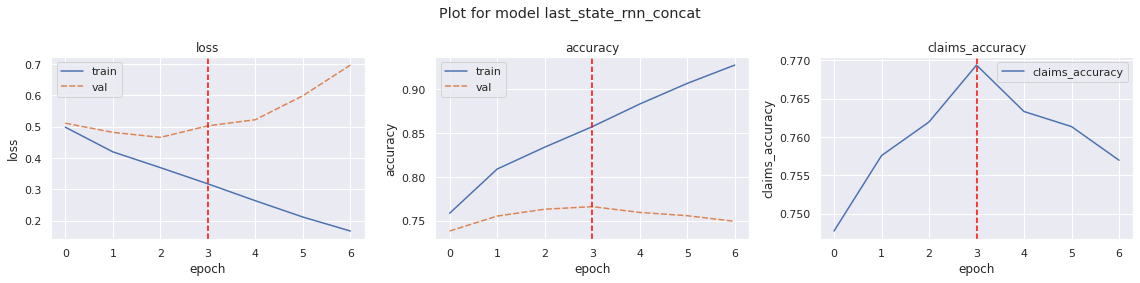

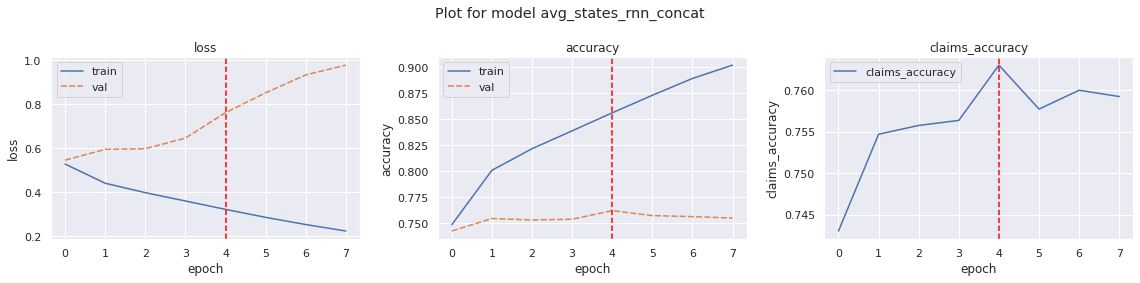

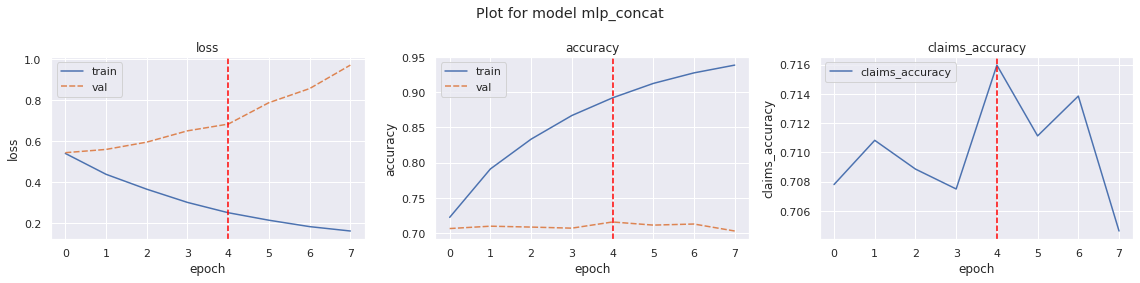

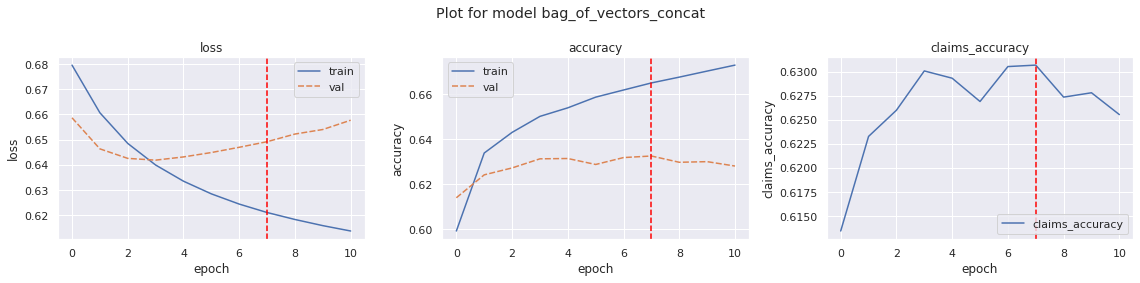

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.83      0.79      3611		           0       0.74      0.83      0.78      3304
           1       0.81      0.71      0.76      3554		           1       0.80      0.71      0.76      3308
		
    accuracy                           0.77      7165		    accuracy                           0.77      6612
   macro avg       0.78      0.77      0.77      7165		   macro avg       0.77      0.77      0.77      6612
weighted avg       0.78      0.77      0.77      7165		weighted avg       0.77      0.77      0.77      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


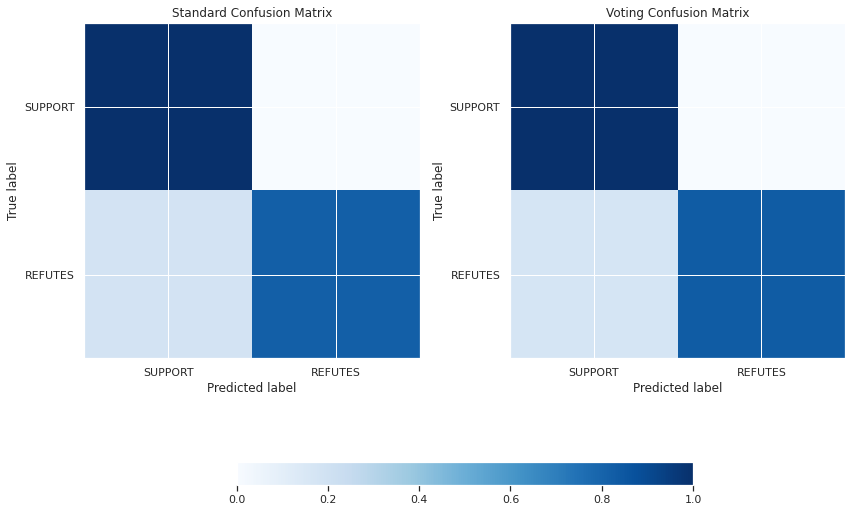

 Showing results for model  avg_states_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.80      0.77      3611		           0       0.75      0.79      0.77      3304
           1       0.78      0.73      0.75      3554		           1       0.78      0.73      0.76      3308
		
    accuracy                           0.76      7165		    accuracy                           0.76      6612
   macro avg       0.77      0.76      0.76      7165		   macro avg       0.76      0.76      0.76      6612
weighted avg       0.77      0.76      0.76      7165		weighted avg       0.76      0.76      0.76      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


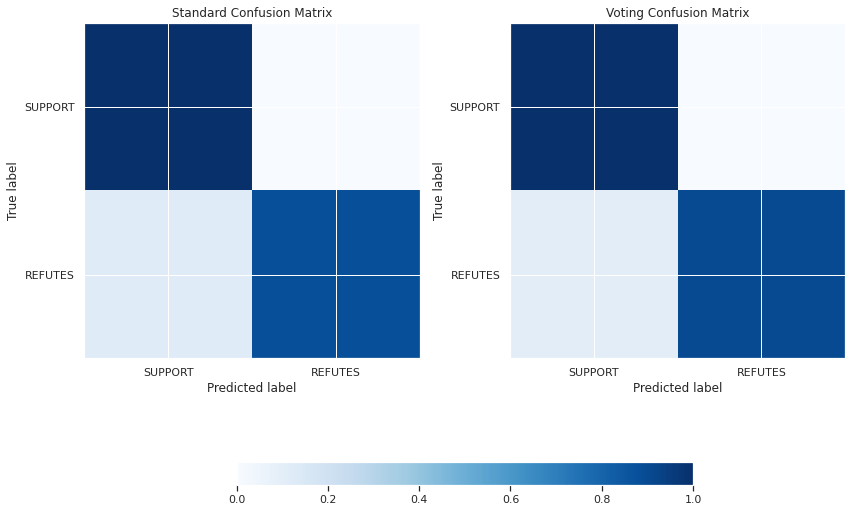

 Showing results for model  mlp_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.70      0.76      0.73      3611		           0       0.70      0.76      0.73      3304
           1       0.74      0.67      0.70      3554		           1       0.74      0.67      0.70      3308
		
    accuracy                           0.72      7165		    accuracy                           0.72      6612
   macro avg       0.72      0.72      0.71      7165		   macro avg       0.72      0.72      0.72      6612
weighted avg       0.72      0.72      0.72      7165		weighted avg       0.72      0.72      0.72      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


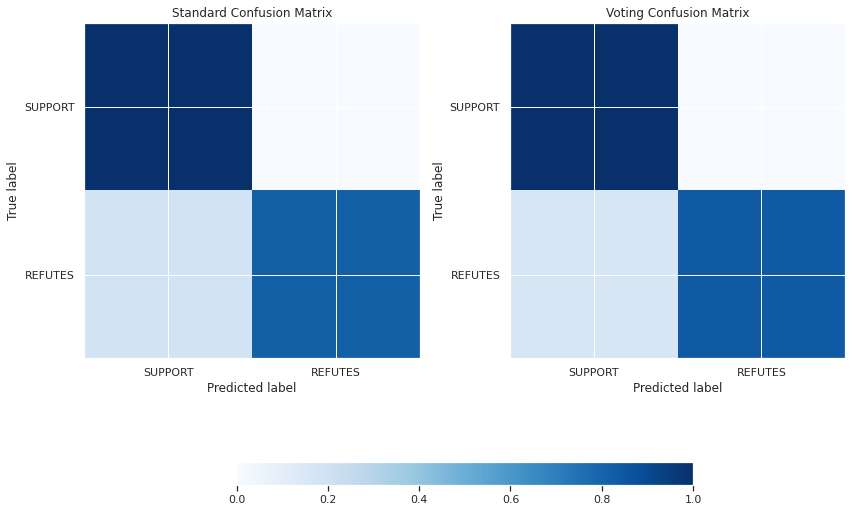

 Showing results for model  bag_of_vectors_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.64      0.63      0.63      3611		           0       0.64      0.61      0.62      3304
           1       0.63      0.64      0.63      3554		           1       0.63      0.65      0.64      3308
		
    accuracy                           0.63      7165		    accuracy                           0.63      6612
   macro avg       0.63      0.63      0.63      7165		   macro avg       0.63      0.63      0.63      6612
weighted avg       0.63      0.63      0.63      7165		weighted avg       0.63      0.63      0.63      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


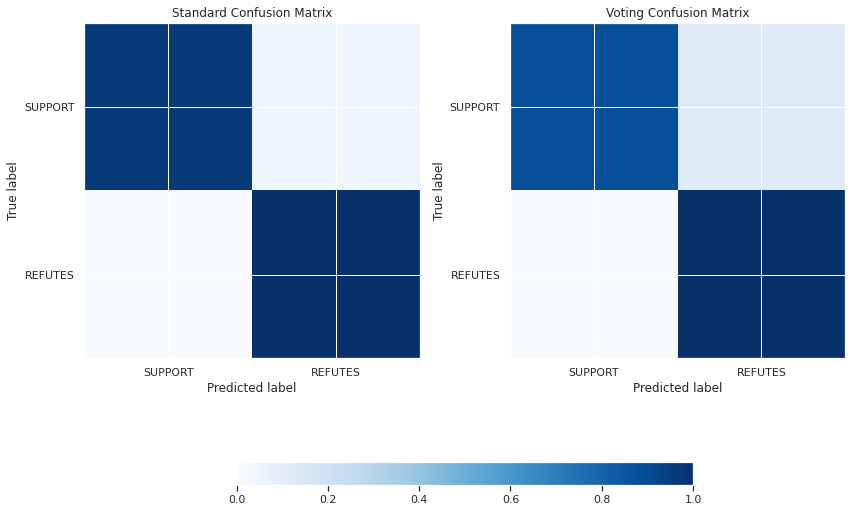

In [41]:
evaluate_models(models, histories)

As shown above, the best model, by means of accuracy score, is the Last State BiLSTM, followed by the Average BiLSTM that shows similar results. The other two models perform badly with respect to the other ones.

Plotting the loss and accuracy progress during training clearly shows that all our models suffer from overfitting from the early stages of the train phase. We tried to mitigate this phenomenon by employing dropout and weight decay, but neither of them proved to be effective in this case.

In [42]:
best_model_name = max(histories, key=lambda x: max(histories[x].history['val_accuracy']))
best_model_name

'last_state_rnn_concat'

### Changing merging strategy

Let's re-train the best model, but using the other two merging strategies and then compare all of them.

In [43]:
models = {best_model_name: models[best_model_name]}
histories = {best_model_name: histories[best_model_name]}

In [44]:
best_model_name = '_'.join(best_model_name.split('_')[:-1])
max_len = X_train_claim_mlp.shape[0] if 'mlp' in best_model_name else None

#### Mean

In [45]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode=best_model_name, 
                  combine='mean', 
                  embeddings=embeddings,
                  max_len=max_len)
run_model(model, models, histories)

Model: "last_state_rnn_mean"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, None, 300)    121047000   ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 512)         1140736     ['embedding_4[0

#### Sum

In [46]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode=best_model_name, 
                  combine='sum', 
                  embeddings=embeddings,
                  max_len=max_len)
run_model(model, models, histories)

Model: "last_state_rnn_sum"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, None, 300)    121047000   ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 512)         1140736     ['embedding_5[0]

### Evaluating merging strategies

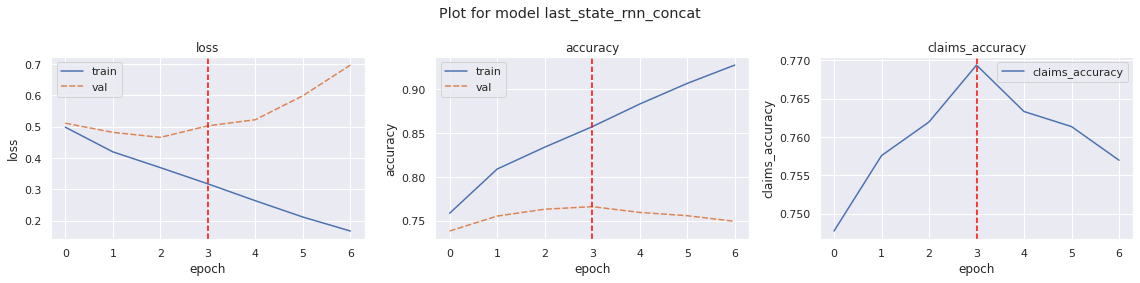

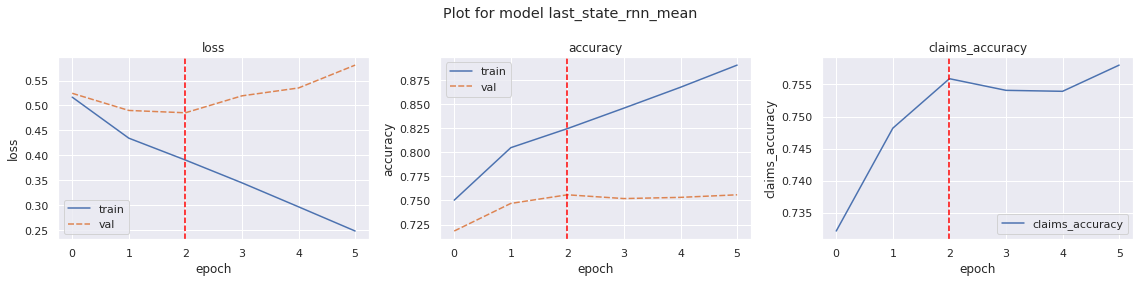

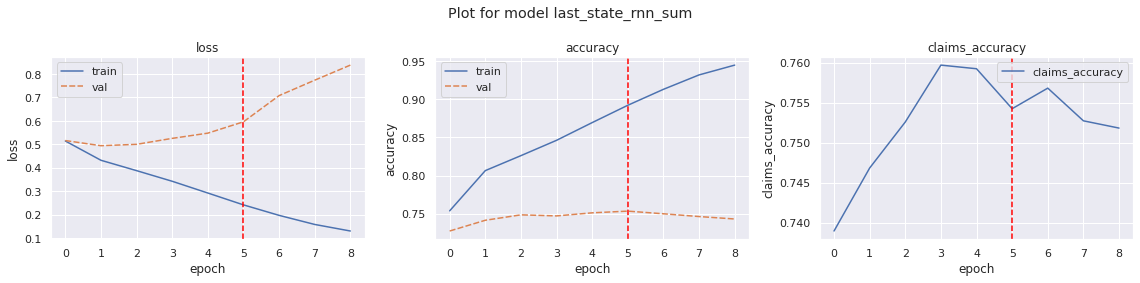

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.83      0.79      3611		           0       0.74      0.83      0.78      3304
           1       0.81      0.71      0.76      3554		           1       0.80      0.71      0.76      3308
		
    accuracy                           0.77      7165		    accuracy                           0.77      6612
   macro avg       0.78      0.77      0.77      7165		   macro avg       0.77      0.77      0.77      6612
weighted avg       0.78      0.77      0.77      7165		weighted avg       0.77      0.77      0.77      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


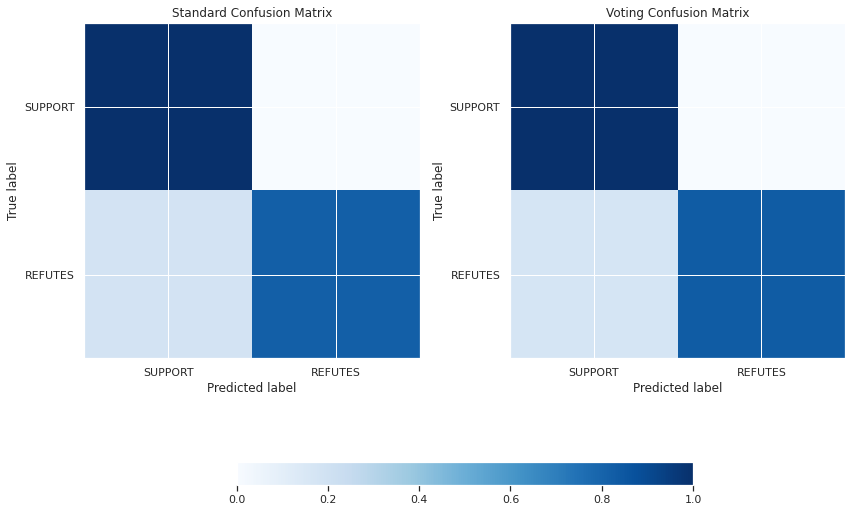

 Showing results for model  last_state_rnn_mean 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.73      0.83      0.78      3611		           0       0.73      0.82      0.77      3304
           1       0.80      0.69      0.74      3554		           1       0.79      0.69      0.74      3308
		
    accuracy                           0.76      7165		    accuracy                           0.76      6612
   macro avg       0.76      0.76      0.76      7165		   macro avg       0.76      0.76      0.75      6612
weighted avg       0.76      0.76      0.76      7165		weighted avg       0.76      0.76      0.75      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


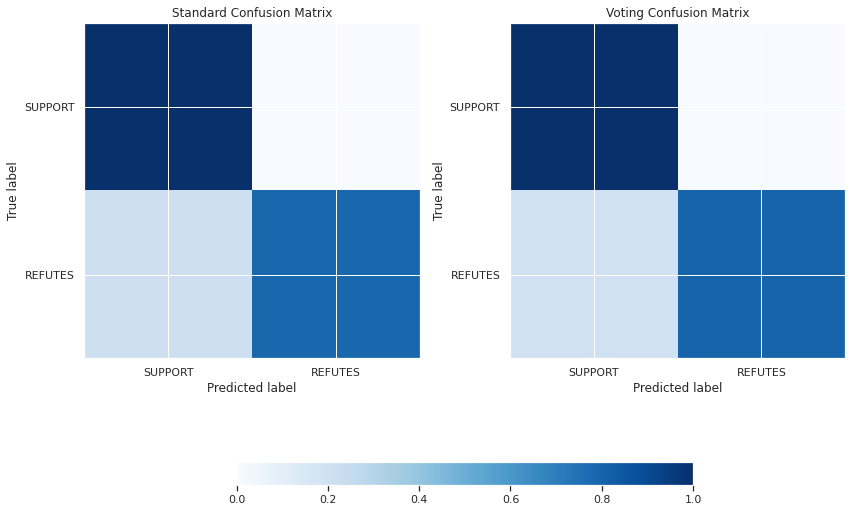

 Showing results for model  last_state_rnn_sum 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.73      0.82      0.77      3611		           0       0.73      0.81      0.77      3304
           1       0.79      0.69      0.74      3554		           1       0.79      0.70      0.74      3308
		
    accuracy                           0.76      7165		    accuracy                           0.75      6612
   macro avg       0.76      0.75      0.75      7165		   macro avg       0.76      0.75      0.75      6612
weighted avg       0.76      0.76      0.75      7165		weighted avg       0.76      0.75      0.75      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


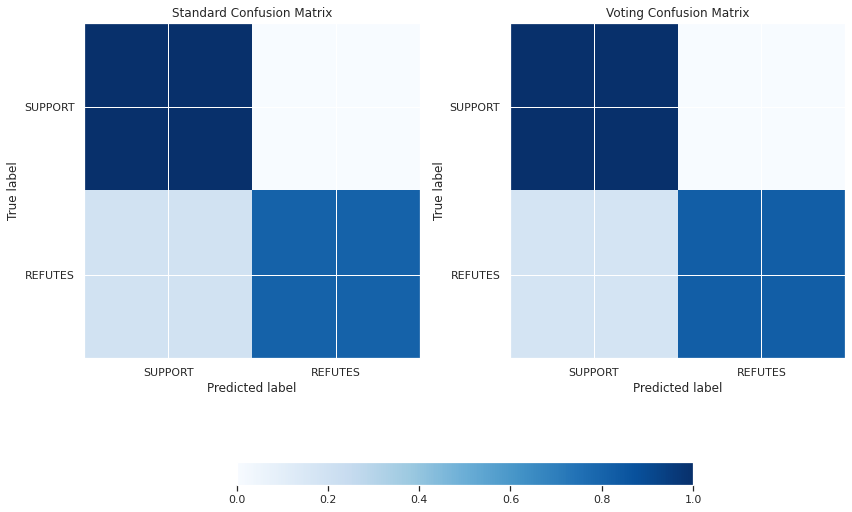

In [47]:
evaluate_models(models, histories)

In [48]:
best_model_name = max(histories, key=lambda x: histories[x].history['val_accuracy'])
best_model_name

'last_state_rnn_concat'

As we can see from the above results, the best model seem to be the one with concatenation, even if the results are pretty similar.

Note that, again, all the models seems to overfit from the early epochs of the training phase.

### Cosine similarity

Let's re-train the best model, but concatenating also the cosine similarity score between the two sentence embeddings before the classifier.

In [49]:
models = {best_model_name: models[best_model_name]}
histories = {best_model_name: histories[best_model_name]}

In [50]:
combine = best_model_name.split('_')[-1]
best_model_name = '_'.join(best_model_name.split('_')[:-1])
max_len = X_train_claim_mlp.shape[0] if 'mlp' in best_model_name else None

In [51]:
model = get_model(vocab_size=len(word_tok.word_index)+1, 
                  mode=best_model_name, 
                  combine=combine, 
                  embeddings=embeddings,
                  max_len=max_len,
                  cosine=True)
run_model(model, models, histories)

Model: "last_state_rnn_concat_cosine"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, None, 300)    121047000   ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 512)         1140736     ['embe

#### Results

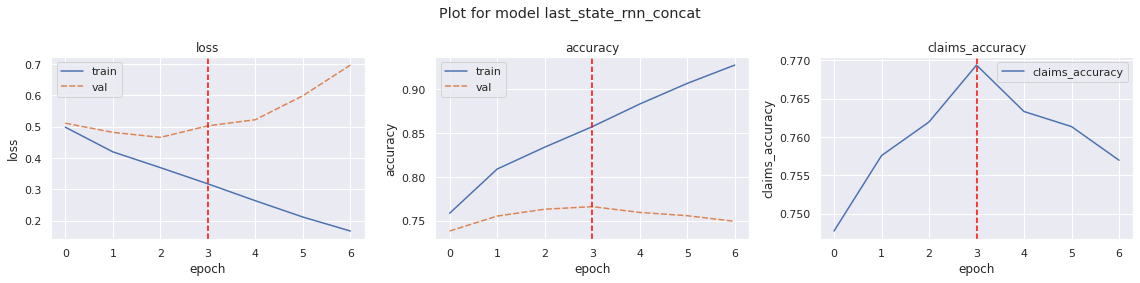

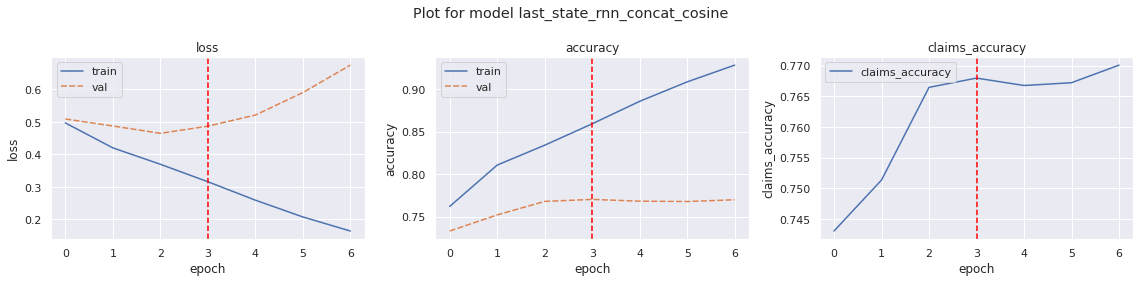

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.83      0.79      3611		           0       0.74      0.83      0.78      3304
           1       0.81      0.71      0.76      3554		           1       0.80      0.71      0.76      3308
		
    accuracy                           0.77      7165		    accuracy                           0.77      6612
   macro avg       0.78      0.77      0.77      7165		   macro avg       0.77      0.77      0.77      6612
weighted avg       0.78      0.77      0.77      7165		weighted avg       0.77      0.77      0.77      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


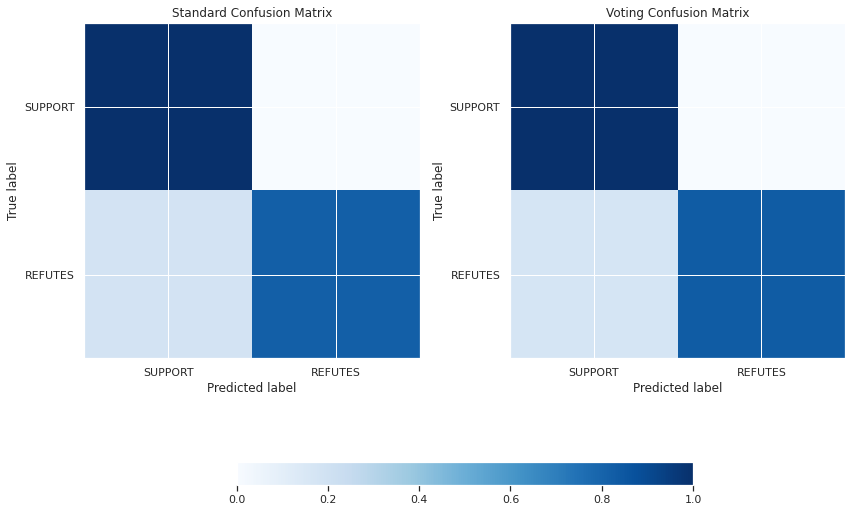

 Showing results for model  last_state_rnn_concat_cosine 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.75      0.82      0.78      3611		           0       0.74      0.82      0.78      3304
           1       0.80      0.72      0.76      3554		           1       0.80      0.72      0.76      3308
		
    accuracy                           0.77      7165		    accuracy                           0.77      6612
   macro avg       0.77      0.77      0.77      7165		   macro avg       0.77      0.77      0.77      6612
weighted avg       0.77      0.77      0.77      7165		weighted avg       0.77      0.77      0.77      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


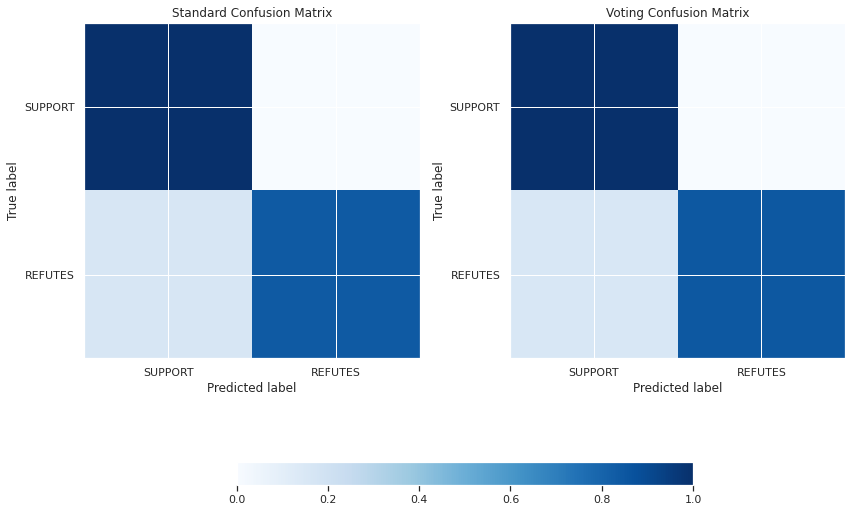

In [52]:
evaluate_models(models, histories)

In [53]:
best_model_name = max(histories, key=lambda x: histories[x].history['val_accuracy'])
best_model_name

'last_state_rnn_concat'

The best model is again the one without any further modifications, even if the results are, in this case, almost identical.

Let's now evaluate the best model on the test set and show the results.

 Showing results for model  last_state_rnn_concat 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.72      0.81      0.76      3606		           0       0.72      0.80      0.76      3309
           1       0.78      0.68      0.73      3583		           1       0.78      0.69      0.73      3304
		
    accuracy                           0.75      7189		    accuracy                           0.75      6613
   macro avg       0.75      0.75      0.75      7189		   macro avg       0.75      0.75      0.75      6613
weighted avg       0.75      0.75      0.75      7189		weighted avg       0.75      0.75      0.75      6613
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


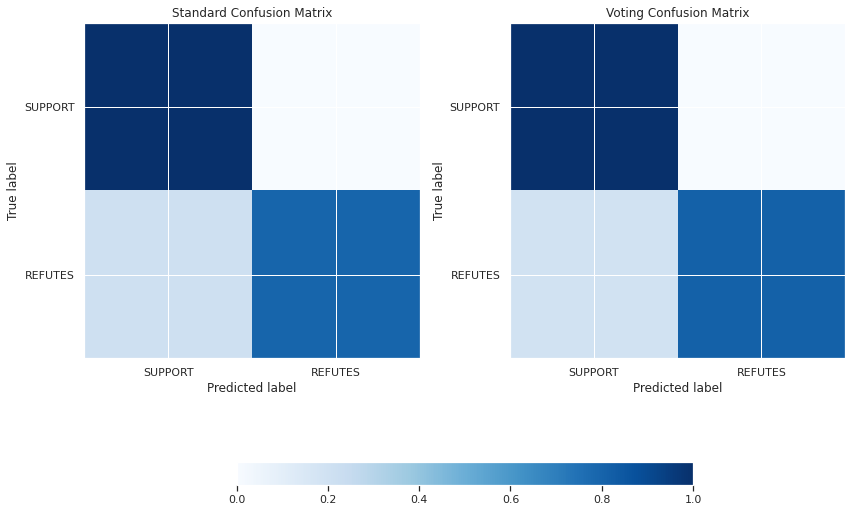

In [54]:
evaluate_test(models[best_model_name])

### Extra: attention mechanism

We will now build, train and evaluate a new model based on a Luong-style attention mechanism. The intuition is to let the model learn how to focus on certain parts of an encoded evidence, given an endcoded word of the claim as a query. To encode the word embeddings we will use a BiLSTM layer.

In [56]:
def get_attention_model(vocab_size, embeddings, trainable=False):
    input_claims = Input(shape=(None,))
    input_evidence = Input(shape=(None,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, weights=[embeddings], trainable=trainable)
    claims_emb = embedding_layer(input_claims)
    evidence_emb = embedding_layer(input_evidence)

    rnn = Bidirectional(LSTM(units=256, return_sequences=True))
    claims_enc = rnn(claims_emb)
    evidence_enc = rnn(evidence_emb)

    evidence_enc = Attention(use_scale=True)([claims_enc, evidence_enc])
    
    evidence_enc = GlobalAveragePooling1D()(evidence_enc)
    claims_enc = GlobalAveragePooling1D()(claims_enc)

    x = Concatenate()([claims_enc, evidence_enc])

    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model([input_claims, input_evidence], x, name='attention')

In [57]:
models = {}
histories = {}
model = get_attention_model(vocab_size=len(word_tok.word_index)+1, 
                            embeddings=embeddings)
run_model(model, models, histories)

Model: "attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, None, 300)    121047000   ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, None, 512)   1140736     ['embedding_7[0][0]',    

2021-12-23 12:39:34.942252: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce RTX 2080 Ti" frequency: 1545 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 6878199808 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


952/952 [==============================] - ETA: 0s - loss: 0.4938 - accuracy: 0.7669

2021-12-23 12:40:21.715886: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce RTX 2080 Ti" frequency: 1545 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 6878199808 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2021-12-23 12:40:26.188644: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce RTX 2080 Ti" frequ

952/952 [==============================] - 66s 56ms/step - loss: 0.4938 - accuracy: 0.7669 - val_loss: 0.4718 - val_accuracy: 0.7555 - val_accuracy_voting: 0.7556
Epoch 2/100
952/952 [==============================] - 45s 48ms/step - loss: 0.4053 - accuracy: 0.8214 - val_loss: 0.4416 - val_accuracy: 0.7786 - val_accuracy_voting: 0.7793
Epoch 3/100
952/952 [==============================] - 45s 48ms/step - loss: 0.3446 - accuracy: 0.8506 - val_loss: 0.4241 - val_accuracy: 0.7954 - val_accuracy_voting: 0.7958
Epoch 4/100
952/952 [==============================] - 45s 48ms/step - loss: 0.2863 - accuracy: 0.8741 - val_loss: 0.4552 - val_accuracy: 0.7987 - val_accuracy_voting: 0.8008
Epoch 5/100
952/952 [==============================] - 45s 48ms/step - loss: 0.2341 - accuracy: 0.8978 - val_loss: 0.4761 - val_accuracy: 0.8004 - val_accuracy_voting: 0.8016
Epoch 6/100
952/952 [==============================] - 45s 47ms/step - loss: 0.1878 - accuracy: 0.9162 - val_loss: 0.5618 - val_accuracy:

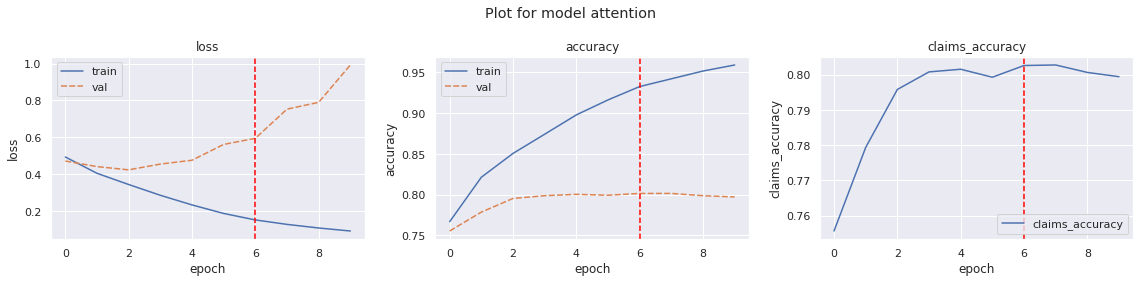

 Showing results for model  attention 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.78      0.85      0.81      3611		           0       0.78      0.84      0.81      3304
           1       0.83      0.75      0.79      3554		           1       0.83      0.76      0.79      3308
		
    accuracy                           0.80      7165		    accuracy                           0.80      6612
   macro avg       0.80      0.80      0.80      7165		   macro avg       0.80      0.80      0.80      6612
weighted avg       0.80      0.80      0.80      7165		weighted avg       0.80      0.80      0.80      6612
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


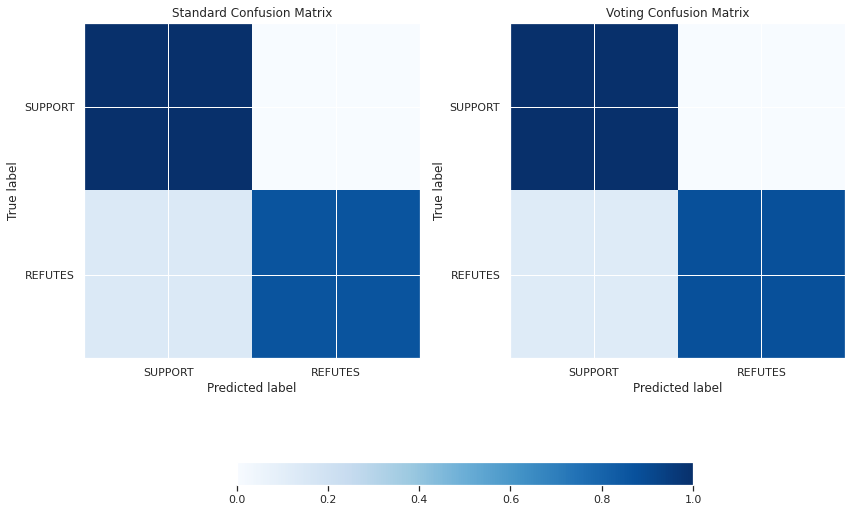

In [58]:
evaluate_models(models, histories)

The results on the validation set have visibly improved w.r.t the best model trained so far, as we can clearly see by looking at both the standard and the voting metrics. 

Let's evaluate the model also on the test set and show the results.

2021-12-23 12:48:04.354134: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce RTX 2080 Ti" frequency: 1545 num_cores: 68 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 5767168 shared_memory_size_per_multiprocessor: 65536 memory_size: 6878199808 bandwidth: 616000000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


 Showing results for model  attention 

			 Standard Report 						 Voting Report
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
           0       0.76      0.84      0.80      3606		           0       0.76      0.84      0.80      3309
           1       0.82      0.73      0.77      3583		           1       0.82      0.74      0.78      3304
		
    accuracy                           0.78      7189		    accuracy                           0.79      6613
   macro avg       0.79      0.78      0.78      7189		   macro avg       0.79      0.79      0.79      6613
weighted avg       0.79      0.78      0.78      7189		weighted avg       0.79      0.79      0.79      6613
		



/public/vairo/prova/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


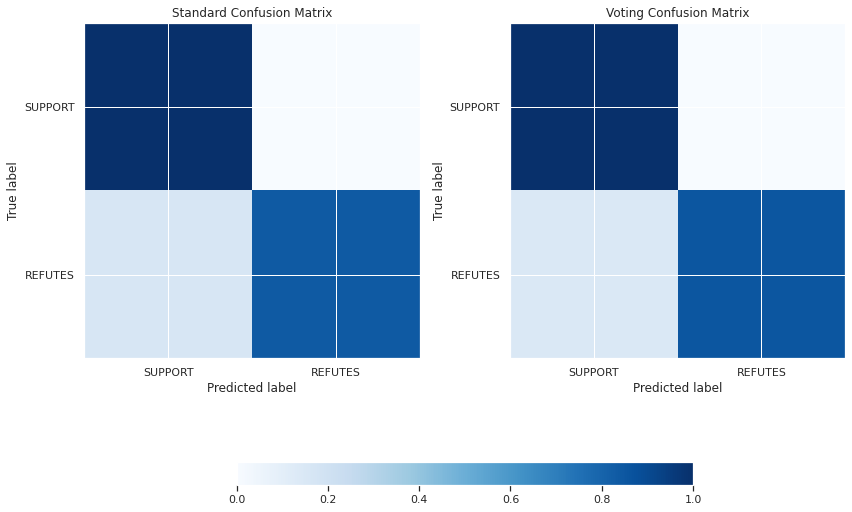

In [59]:
evaluate_test(model)

The above confusion matrix shows that this final model misclassifies mostly the class "REFUTES", which is also the minority class in the training set. Indeed, we addressed this problem during training by employing class weights but this did not really solve the issue. Another option could have been that of re-sampling the minority class or augmenting the dataset (using techniquest like back translation) in order to reduce the class imbalance in the training set.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e9c61a29-08c2-4eab-ac12-cdf7b972c02c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>